In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from util import Util
from cost_data_manager import CostDataManager
from matplotlib.backends.backend_pdf import PdfPages
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn import metrics as m
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from matplotlib.backends.backend_pdf import PdfPages

####
#dodano
####

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

# configuration
############################################################
np.random.seed(1001)
report_directory = "reports" 

excel_file_video = r"video_dataset_with_costs(cost).xlsx"
excel_file_mrs = r"mrs_dataset_with_costs(cost).xlsx"

# set data mode ('mrs' or 'video')
data_mode = "video"

if data_mode == "mrs":
    excel_file = excel_file_mrs
elif data_mode == "video":
    excel_file = excel_file_video


cost_labels = [
                'Century Link', 
                'Google', 
                #'Azure', 
                'Amazon', 
                #'Oracle', 
                'Alibaba', 
                'DigitalOcean'
             ]
used_features = ['Users',
                 #'Avg. CPU utilization (%)',
                 'Max CPU utilization (%)',
                 'NW Egress (GB)',
                 #'Avg RAM (unused, KiB)',
                 'Avg RAM used (MB)',
                 #'Disk write bytes rate',
                 #'Disk read bytes',
                 #'Used storage(image size, GB)',
                ] 
outcome_label = 'cost'
############################################################

dataManager = CostDataManager(excel_file, outcome_label, cost_labels, used_features, data_mode=data_mode)
dataManager.load()
dataManager.exportDataset()  

def transformX(X):
    scaler = StandardScaler()

    X1 = scaler.fit_transform(X)
    X = pd.DataFrame(X1, columns=X.columns)      
    return X

def transformY(Y):
    return Y
    #data = Y.copy().values
    #data = np.sqrt(data)
    #ret = pd.Series(data)
    #return ret 
def invTrans(X):
    return X

dataManager.setXTransform(transformX)
dataManager.setYTransform(transformY)

m_all = dataManager.getMetrics()
if data_mode == 'mrs':
    m_large = dataManager.getMetricsDBLarge()
    m_xlarge = dataManager.getMetricsDBXLarge()
elif data_mode == 'video':
    m_small = dataManager.getMetricsVideoDBLarge()
    m_medium = dataManager.getMetricsVideoDBMedium()
    m_large = dataManager.getMetricsVideoDBSmall()

working_metrics = m_large
working_metrics_label = "large"
print("Total working data:", len(working_metrics))
util = Util()
util.setInvTrans(invTrans)
working_metrics.head()
X,Y = dataManager.getXY_panda(working_metrics)


Using TensorFlow backend.


0 Century Link
1 Google
2 Amazon
3 Alibaba
4 DigitalOcean
6 features removed (std +/- 3) -  all
5 features removed (std +/- 3) -  large
5 features removed (std +/- 3) -  medium
15 features removed (std +/- 3) -  small

COST
0        530.221737
1       4551.806759
2       6069.014745
3       7722.316874
4       9249.843030
5      10933.576904
6      12518.687140
7      14174.159494
8      15798.929082
9      17435.012500
10     26842.244122
11     28647.421053
12     30400.106166
13     32157.228895
14     33972.047920
15     35864.270908
16       432.183004
17      1621.280223
18      3173.265154
19      6288.579872
20      7833.274069
21     10806.221632
22     12451.849725
23     14083.496768
24     15722.018540
25     17309.536566
26     20692.920373
27     22366.492631
28     24009.724619
29     25765.211888
           ...     
209      648.485031
210     1271.547974
211     1580.486814
212     2175.076326
213     2504.201945
214     2830.531354
215     3158.235708
216     3475.739

# Neural net

In [2]:
import keras
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

#def baseline_model_1(pen=0.01):
def baseline_model_1():
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = X.shape[1]))
    #model.add(Dense(32, activation = 'relu', kernel_initializer='normal', input_dim = X.shape[1]))
    #model.add(Dense(32, activation = 'tanh', input_dim = X.shape[1]))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 1, activation='relu'))
    
    adam = keras.optimizers.Adamax(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)    
    #model.compile(optimizer = 'rmsprop', loss = 'mse', metrics=['mse','mae'])
    model.compile(optimizer = 'rmsprop', loss = 'mse')
    return model

def baseline_model_2(pen=0.01):
    
    model = Sequential()
    #model.add(Dense(32, activation = 'relu', input_dim = X.shape[1]))
    #model.add(Dense(32, activation = 'relu', kernel_initializer='normal', input_dim = X.shape[1]))
    model.add(Dense(32, activation = 'tanh', kernel_initializer='glorot_uniform', input_dim = X.shape[1]))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 1, activation='relu'))
    
    adam = keras.optimizers.Adamax(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)    
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics=['mse','mae'])
    return model

In [3]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

#d = dict()
#for i in np.arange(0.0, 0.1, 0.02):
    # Splitting the dataset into the Training set and Test set
X,Y = dataManager.getXY_panda(working_metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

    #Zakomentirano za Permutation Importance 
    ######### START
    
model_1 = baseline_model_1()
    #model_2 = baseline_model_2(i)
    
    #model.summary()

    # Fitting the ANN to the Training set
    #history_1 = model_1.fit(X_train, Y_train, batch_size = 50, epochs = 1000, verbose=False)
    ##history_2 = model_2.fit(X_train, Y_train, batch_size = 50, epochs = 500, verbose=False)

    #Y_pred_1 = model_1.predict(X_test)
    ##Y_pred_2 = model_2.predict(X_test)
    
    #Y_pred_1 = np.concatenate( Y_pred_1, axis=0 )
    ##Y_pred_2 = np.concatenate( Y_pred_2, axis=0 )
    
    #mae_1 = m.mean_absolute_error(Y_test, Y_pred_1)
    ##mae_2 = m.mean_absolute_error(Y_test, Y_pred_2)
    
    #print(i, mae_1)
    #d[i] = mae_1
    
    ######### END
    
my_model = KerasRegressor(build_fn=baseline_model_1, batch_size = 50, epochs = 1000)    
my_model.fit(X_train,Y_train)

#Y_pred_1 = my_model.predict(X_test)
#util.regression_report(Y_test, Y_pred_1, "NN", X.shape[1])

perm = PermutationImportance(my_model, n_iter=150, random_state=1).fit(X_test,Y_test)
print("Eli5.show_weights")
print("=================")
print("")
eli5.show_weights(perm, feature_names = X.columns.tolist())
    #print("=================")

Epoch 1/1000
49/49 [==============================] - 0s 8ms/step - loss: 360055840.0000
Epoch 2/1000
49/49 [==============================] - 0s 41us/step - loss: 360048096.0000
Epoch 3/1000
49/49 [==============================] - 0s 41us/step - loss: 360040864.0000
Epoch 4/1000
49/49 [==============================] - 0s 41us/step - loss: 360034560.0000
Epoch 5/1000
49/49 [==============================] - 0s 41us/step - loss: 360028000.0000
Epoch 6/1000
49/49 [==============================] - 0s 41us/step - loss: 360020928.0000
Epoch 7/1000
49/49 [==============================] - 0s 41us/step - loss: 360013312.0000
Epoch 8/1000
49/49 [==============================] - 0s 61us/step - loss: 360005184.0000
Epoch 9/1000
49/49 [==============================] - 0s 41us/step - loss: 359996352.0000
Epoch 10/1000
49/49 [==============================] - 0s 20us/step - loss: 359986432.0000
Epoch 11/1000
49/49 [==============================] - 0s 41us/step - loss: 359975616.0000
Epoch 12/

Epoch 91/1000
49/49 [==============================] - 0s 102us/step - loss: 339489632.0000
Epoch 92/1000
49/49 [==============================] - 0s 122us/step - loss: 338705984.0000
Epoch 93/1000
49/49 [==============================] - 0s 41us/step - loss: 337901472.0000
Epoch 94/1000
49/49 [==============================] - 0s 41us/step - loss: 337074400.0000
Epoch 95/1000
49/49 [==============================] - 0s 102us/step - loss: 336226400.0000
Epoch 96/1000
49/49 [==============================] - 0s 20us/step - loss: 335356224.0000
Epoch 97/1000
49/49 [==============================] - 0s 61us/step - loss: 334465856.0000
Epoch 98/1000
49/49 [==============================] - 0s 41us/step - loss: 333552576.0000
Epoch 99/1000
49/49 [==============================] - 0s 41us/step - loss: 332613824.0000
Epoch 100/1000
49/49 [==============================] - 0s 102us/step - loss: 331649728.0000
Epoch 101/1000
49/49 [==============================] - 0s 41us/step - loss: 33066272

Epoch 180/1000
49/49 [==============================] - 0s 122us/step - loss: 164744592.0000
Epoch 181/1000
49/49 [==============================] - 0s 41us/step - loss: 161730960.0000
Epoch 182/1000
49/49 [==============================] - 0s 41us/step - loss: 158713776.0000
Epoch 183/1000
49/49 [==============================] - 0s 61us/step - loss: 155698528.0000
Epoch 184/1000
49/49 [==============================] - 0s 143us/step - loss: 152678112.0000
Epoch 185/1000
49/49 [==============================] - 0s 20us/step - loss: 149652416.0000
Epoch 186/1000
49/49 [==============================] - 0s 41us/step - loss: 146634624.0000
Epoch 187/1000
49/49 [==============================] - 0s 61us/step - loss: 143613920.0000
Epoch 188/1000
49/49 [==============================] - 0s 20us/step - loss: 140601232.0000
Epoch 189/1000
49/49 [==============================] - 0s 41us/step - loss: 137591792.0000
Epoch 190/1000
49/49 [==============================] - 0s 61us/step - loss: 1

Epoch 270/1000
49/49 [==============================] - 0s 61us/step - loss: 26354318.0000
Epoch 271/1000
49/49 [==============================] - 0s 41us/step - loss: 26116660.0000
Epoch 272/1000
49/49 [==============================] - 0s 41us/step - loss: 25880662.0000
Epoch 273/1000
49/49 [==============================] - 0s 20us/step - loss: 25644854.0000
Epoch 274/1000
49/49 [==============================] - 0s 41us/step - loss: 25409722.0000
Epoch 275/1000
49/49 [==============================] - 0s 41us/step - loss: 25175648.0000
Epoch 276/1000
49/49 [==============================] - 0s 41us/step - loss: 24941732.0000
Epoch 277/1000
49/49 [==============================] - 0s 41us/step - loss: 24707996.0000
Epoch 278/1000
49/49 [==============================] - 0s 41us/step - loss: 24474382.0000
Epoch 279/1000
49/49 [==============================] - 0s 61us/step - loss: 24243070.0000
Epoch 280/1000
49/49 [==============================] - 0s 41us/step - loss: 24012528.0000

Epoch 360/1000
49/49 [==============================] - 0s 122us/step - loss: 9077818.0000
Epoch 361/1000
49/49 [==============================] - 0s 41us/step - loss: 8946272.0000
Epoch 362/1000
49/49 [==============================] - 0s 20us/step - loss: 8812863.0000
Epoch 363/1000
49/49 [==============================] - 0s 61us/step - loss: 8683377.0000
Epoch 364/1000
49/49 [==============================] - 0s 82us/step - loss: 8552775.0000
Epoch 365/1000
49/49 [==============================] - 0s 20us/step - loss: 8425224.0000
Epoch 366/1000
49/49 [==============================] - 0s 122us/step - loss: 8297615.5000
Epoch 367/1000
49/49 [==============================] - 0s 61us/step - loss: 8173224.5000
Epoch 368/1000
49/49 [==============================] - 0s 41us/step - loss: 8049829.0000
Epoch 369/1000
49/49 [==============================] - 0s 41us/step - loss: 7927650.5000
Epoch 370/1000
49/49 [==============================] - 0s 41us/step - loss: 7805568.5000
Epoch 37

Epoch 451/1000
49/49 [==============================] - 0s 41us/step - loss: 1941234.2500
Epoch 452/1000
49/49 [==============================] - 0s 61us/step - loss: 1903466.2500
Epoch 453/1000
49/49 [==============================] - 0s 61us/step - loss: 1867787.8750
Epoch 454/1000
49/49 [==============================] - 0s 41us/step - loss: 1831433.5000
Epoch 455/1000
49/49 [==============================] - 0s 41us/step - loss: 1797569.1250
Epoch 456/1000
49/49 [==============================] - 0s 41us/step - loss: 1761908.1250
Epoch 457/1000
49/49 [==============================] - 0s 41us/step - loss: 1729825.1250
Epoch 458/1000
49/49 [==============================] - 0s 20us/step - loss: 1697956.1250
Epoch 459/1000
49/49 [==============================] - 0s 61us/step - loss: 1666171.0000
Epoch 460/1000
49/49 [==============================] - 0s 41us/step - loss: 1636160.8750
Epoch 461/1000
49/49 [==============================] - 0s 61us/step - loss: 1605140.7500
Epoch 462/

Epoch 543/1000
49/49 [==============================] - 0s 102us/step - loss: 436310.5625
Epoch 544/1000
49/49 [==============================] - 0s 61us/step - loss: 430559.7500
Epoch 545/1000
49/49 [==============================] - 0s 61us/step - loss: 426256.8438
Epoch 546/1000
49/49 [==============================] - 0s 82us/step - loss: 420775.3125
Epoch 547/1000
49/49 [==============================] - 0s 61us/step - loss: 416772.9062
Epoch 548/1000
49/49 [==============================] - 0s 41us/step - loss: 412616.2500
Epoch 549/1000
49/49 [==============================] - 0s 20us/step - loss: 409350.4062
Epoch 550/1000
49/49 [==============================] - 0s 41us/step - loss: 404004.0938
Epoch 551/1000
49/49 [==============================] - 0s 82us/step - loss: 400598.6875
Epoch 552/1000
49/49 [==============================] - 0s 122us/step - loss: 396106.2188
Epoch 553/1000
49/49 [==============================] - 0s 20us/step - loss: 393745.7500
Epoch 554/1000
49/4

Epoch 635/1000
49/49 [==============================] - 0s 82us/step - loss: 207167.2188
Epoch 636/1000
49/49 [==============================] - 0s 41us/step - loss: 205291.0469
Epoch 637/1000
49/49 [==============================] - 0s 41us/step - loss: 204654.8438
Epoch 638/1000
49/49 [==============================] - 0s 82us/step - loss: 202824.8906
Epoch 639/1000
49/49 [==============================] - 0s 41us/step - loss: 202771.1406
Epoch 640/1000
49/49 [==============================] - 0s 82us/step - loss: 201731.3438
Epoch 641/1000
49/49 [==============================] - 0s 143us/step - loss: 201411.8750
Epoch 642/1000
49/49 [==============================] - 0s 41us/step - loss: 199170.8438
Epoch 643/1000
49/49 [==============================] - 0s 41us/step - loss: 198309.0156
Epoch 644/1000
49/49 [==============================] - 0s 102us/step - loss: 196254.1875
Epoch 645/1000
49/49 [==============================] - 0s 61us/step - loss: 195794.1875
Epoch 646/1000
49/4

Epoch 727/1000
49/49 [==============================] - 0s 82us/step - loss: 137785.3281
Epoch 728/1000
49/49 [==============================] - 0s 20us/step - loss: 136227.7344
Epoch 729/1000
49/49 [==============================] - 0s 122us/step - loss: 136500.0156
Epoch 730/1000
49/49 [==============================] - 0s 41us/step - loss: 135005.2344
Epoch 731/1000
49/49 [==============================] - 0s 41us/step - loss: 135041.4531
Epoch 732/1000
49/49 [==============================] - 0s 41us/step - loss: 134365.9844
Epoch 733/1000
49/49 [==============================] - 0s 61us/step - loss: 134688.4219
Epoch 734/1000
49/49 [==============================] - 0s 41us/step - loss: 133778.5781
Epoch 735/1000
49/49 [==============================] - 0s 82us/step - loss: 134153.8281
Epoch 736/1000
49/49 [==============================] - 0s 102us/step - loss: 133028.9219
Epoch 737/1000
49/49 [==============================] - 0s 20us/step - loss: 133390.3281
Epoch 738/1000
49/4

Epoch 819/1000
49/49 [==============================] - 0s 102us/step - loss: 104886.9219
Epoch 820/1000
49/49 [==============================] - 0s 41us/step - loss: 104276.4922
Epoch 821/1000
49/49 [==============================] - 0s 41us/step - loss: 104191.5625
Epoch 822/1000
49/49 [==============================] - 0s 41us/step - loss: 103451.5781
Epoch 823/1000
49/49 [==============================] - 0s 20us/step - loss: 103150.5000
Epoch 824/1000
49/49 [==============================] - 0s 41us/step - loss: 102779.0234
Epoch 825/1000
49/49 [==============================] - 0s 41us/step - loss: 104201.5781
Epoch 826/1000
49/49 [==============================] - 0s 41us/step - loss: 102735.0547
Epoch 827/1000
49/49 [==============================] - 0s 41us/step - loss: 102821.1562
Epoch 828/1000
49/49 [==============================] - 0s 41us/step - loss: 101771.9922
Epoch 829/1000
49/49 [==============================] - 0s 41us/step - loss: 101904.6719
Epoch 830/1000
49/49

Epoch 912/1000
49/49 [==============================] - 0s 41us/step - loss: 86703.9688
Epoch 913/1000
49/49 [==============================] - 0s 163us/step - loss: 86875.6641
Epoch 914/1000
49/49 [==============================] - 0s 102us/step - loss: 86572.5625
Epoch 915/1000
49/49 [==============================] - 0s 20us/step - loss: 87187.1328
Epoch 916/1000
49/49 [==============================] - 0s 61us/step - loss: 86834.2734
Epoch 917/1000
49/49 [==============================] - 0s 41us/step - loss: 86708.4688
Epoch 918/1000
49/49 [==============================] - 0s 143us/step - loss: 86291.4766
Epoch 919/1000
49/49 [==============================] - 0s 41us/step - loss: 86669.1094
Epoch 920/1000
49/49 [==============================] - 0s 61us/step - loss: 86191.4453
Epoch 921/1000
49/49 [==============================] - 0s 41us/step - loss: 86964.3281
Epoch 922/1000
49/49 [==============================] - 0s 41us/step - loss: 85766.8672
Epoch 923/1000
49/49 [=======

21/21 [==============================] - 0s 48us/step


21/21 [==============================] - 0s 48us/step


21/21 [==============================] - 0s 48us/step


21/21 [==============================] - 0s 667us/step


21/21 [==============================] - 0s 190us/step


21/21 [==============================] - 0s 48us/step


21/21 [==============================] - 0s 143us/step


21/21 [==============================] - 0s 48us/step
Eli5.show_weights



Weight,Feature
202750194.9133 ± 113926338.0668,Google
167597129.3133 ± 107577617.3132,Alibaba
66743004.6867 ± 54000714.5944,Amazon
51571863.8733 ± 30623158.3723,NW Egress (GB)
26672708.6200 ± 16991901.8109,Users
10723753.2467 ± 7234786.4227,Avg RAM used (MB)
8004825.6033 ± 10296140.6646,Century Link
1231984.2367 ± 1425878.7570,Max CPU utilization (%)


NameError: name 'Y_pred_1' is not defined

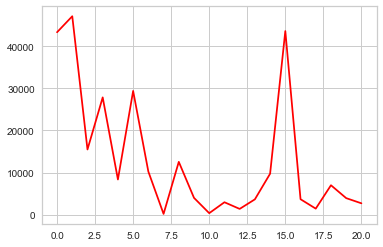

In [4]:
plt.plot(Y_test.values, color = 'red', label = 'Real data')
plt.plot(Y_pred_1, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()



model_info = {}
model_info['model'] = model_1
model_info['X_train'] = X_train
model_info['X_test'] = X_test
model_info['Y_train'] = Y_train
model_info['Y_test'] = Y_test
model_info['predicted'] = model_1.predict(X_test)[:,0]

In [ ]:
# summarize history for loss
with PdfPages(report_directory + "/cost_" + data_mode + '_graphs_NN_model_loss.pdf') as pdf:
    f, ax = plt.subplots()
    plt.plot(history_1.history['loss'], color = 'red', label = 'relu')
    #plt.plot(history_2.history['loss'], color = 'blue', label = 'tanh')
    #plt.title('model loss')
    plt.ylabel('model loss', fontsize = 'xx-large')
    plt.xlabel('number of epochs', fontsize = 'xx-large')
    plt.legend(fontsize = 'xx-large')
    plt.tick_params(axis='both', labelsize=16)
    plt.show()
    pdf.savefig(f, bbox_inches='tight')
    

print('Model_1')
print('=========')
print('')
util.regression_report(Y_test, Y_pred_1, "NN", X.shape[1])
print('')
print('')
print('Model_2')
print('=========')
print('')
#util.regression_report(Y_test, Y_pred_2, "NN", X.shape[1])

#import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/SummerCamp/Anaconda3/pkgs/graphviz-2.38.0-4/Library/bin/graphviz'
#from keras.utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Analysis

## Residuals 

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
plt.scatter(model_1.predict(X_train)[:,0], util.get_standard_residuals(model_1.predict(X_train)[:,0],Y_train), c='b', s=40, alpha=0.5)
plt.scatter(model_1.predict(X_test)[:,0], util.get_standard_residuals(model_1.predict(X_test)[:,0],Y_test), c='g', s=40, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=50)
plt.title(str(model_1))
plt.ylabel('Standard Residuals')
plt.xlabel('Fitted values')	   
plt.title("Residuals")
plt.show()

## Predicted vs Original

In [ ]:
with PdfPages(report_directory + "/cost_" + data_mode + '_graphs_NN_predicted_vs_original.pdf') as pdf:
    f, ax = plt.subplots(figsize=(6, 6))
    util.pred_true_graph(model_info, "NN")
    #plt.legend(fontsize = 'xx-large')
    plt.show()
    pdf.savefig(f, bbox_inches='tight')
